In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

In [81]:
train = pd.read_csv("train.csv")
oil = pd.read_csv("oil.csv")
stores = pd.read_csv("stores.csv")

### Goal: You will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [82]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [83]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [84]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [85]:
train.describe()['sales']

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

In [86]:
train["date"] = pd.to_datetime(train["date"])
train["year"] = train["date"].dt.year
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
year                    int32
dtype: object

In [87]:
train = train.merge(stores, how="right", on="store_nbr")
train.head()


,id,date,store_nbr,family,sales,onpromotion,year,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,Quito,Pichincha,D,13


In [88]:
#Lets look at store sales of a random store
store_1 = train[train["store_nbr"] == 1]
store_1.groupby("date")

<Axes: xlabel='date', ylabel='sales'>

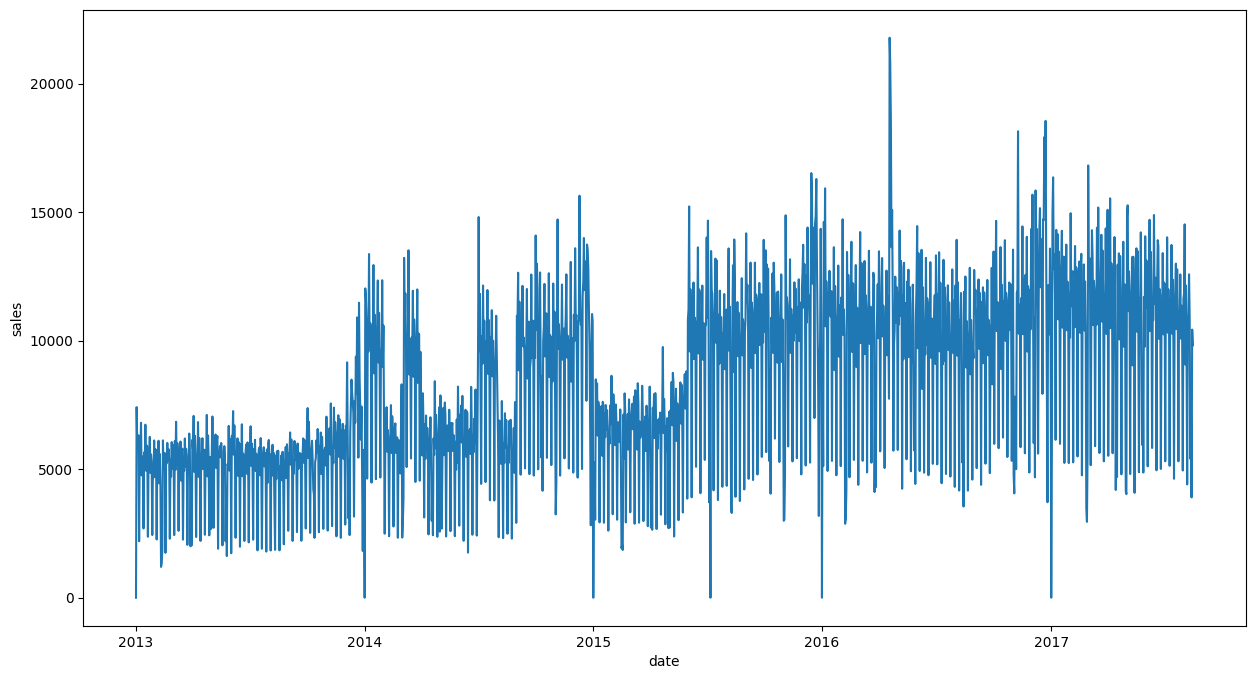

In [89]:
sum_sales = store_1.groupby(["date"], as_index=False)["sales"].sum()
sum_sales = pd.DataFrame(sum_sales)
plt.figure(figsize=(15,8))
sns.lineplot(sum_sales, x="date", y="sales")

In [90]:
sum_sales.head()

,date,sales
0,2013-01-01,0.000000
1,2013-01-02,7417.148000
2,2013-01-03,5873.244001
3,2013-01-04,5919.879001
4,2013-01-05,6318.785010


<Axes: title={'center': 'Autocorrelation'}>

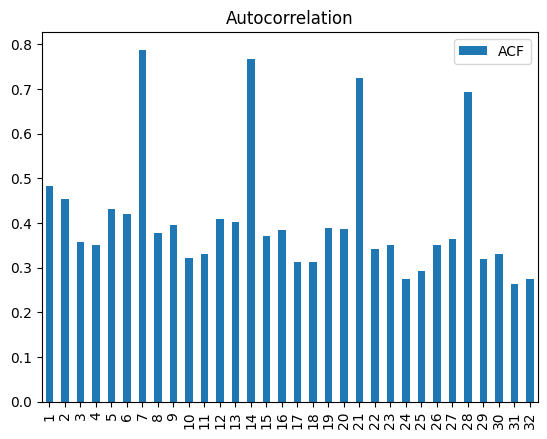

In [91]:
from arch.unitroot import ADF
import statsmodels.api as sm
acf = pd.DataFrame(sm.tsa.stattools.acf(sum_sales["sales"]), columns=["ACF"])
acf[1:].plot(kind="bar", title="Autocorrelation")

In [92]:
adf = ADF(sum_sales["sales"])
adf.summary()

Test Statistic,-2.980
P-value,0.037
Lags,25


Fail to reject null hypothesis at the 5% level, the process contains a unit root. Lets take first difference, see what happens then.

<Axes: xlabel='date', ylabel='First_diff'>

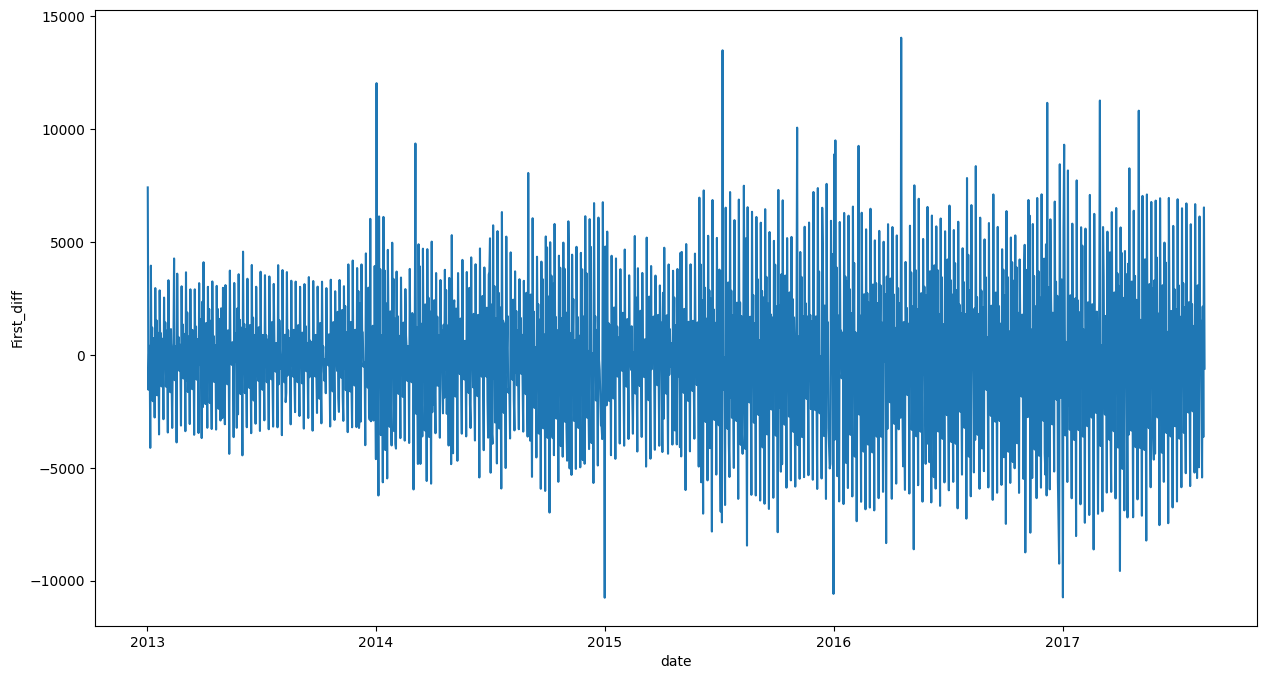

In [93]:
sum_sales["First_diff"] = sum_sales["sales"].diff()
sns.lineplot(sum_sales, x="date", y="First_diff")

<Axes: title={'center': 'Autocorrelation'}>

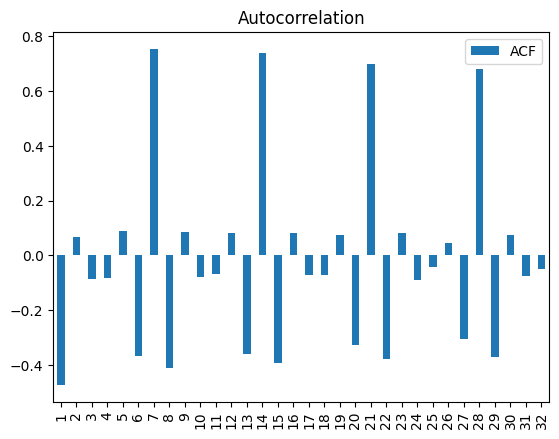

In [98]:
acf = pd.DataFrame(sm.tsa.stattools.acf(sum_sales["First_diff"], missing="drop"), columns=["ACF"])
acf[1:].plot(kind="bar", title="Autocorrelation")

In [101]:
adf = ADF(sum_sales["First_diff"][~sum_sales["First_diff"].index.isin([0])])
adf.summary()

Test Statistic,-10.025
P-value,0.000
Lags,25


Reject null hypothesis, the process is now (weakly) stationary. Lets investigate the residuals. Right now it seems that an AR(1) process will be the model of best fit, however all that depends on the distribution of the residuals.

<Axes: >

<Figure size 1500x800 with 0 Axes>

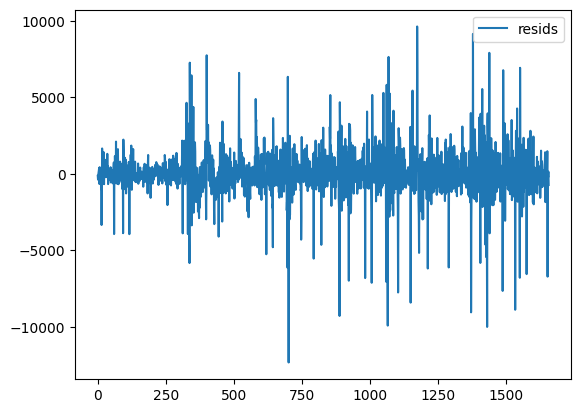

In [107]:
resid_red = adf.regression
resid = pd.DataFrame(resid_red.resid)
resid.columns = ["resids"]
plt.figure(figsize=(15,8))
resid.plot()